# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 
 

**Heads-up**: Our MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting ./cs231n/datasets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-labels-idx1-ubyte.gz


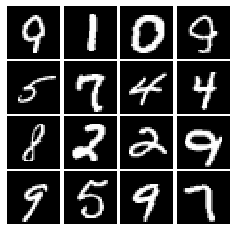

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [4]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    
    # If x is below 0 returns alpha*x else it will return x.
    activation = tf.where(x < 0, alpha*x, x)
    
    return activation


Test your leaky ReLU implementation. You should get errors < 1e-10

In [5]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [6]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    random_noise = tf.random.uniform(maxval=1,minval=-1,shape=[batch_size, dim])
    
    return random_noise


Make sure noise is the correct shape and type:

In [7]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms. For initialization, just use the default initializer used by the `tf.layers` functions.

Architecture:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with output size 1 
 
The output of the discriminator should thus have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [8]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        
        fc1 = tf.layers.dense(inputs=x, units=256, activation=leaky_relu)
        fc2 = tf.layers.dense(inputs=fc1, units=256, activation=leaky_relu)
        logits = tf.layers.dense(inputs=fc2, units=1)
    
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [9]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms. Note that you can use the tf.nn module to access activation functions. Once again, use the default initializers for parameters.

Architecture:
 * Fully connected layer with inupt size tf.shape(z)[1] (the number of noise dimensions) and output size 1024
 * `ReLU`
 * Fully connected layer with output size 1024 
 * `ReLU`
 * Fully connected layer with output size 784
 * `TanH` (To restrict every element of the output to be in the range [-1,1])

In [10]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        
        fc1 = tf.layers.dense(inputs=z, units=1024, activation=tf.nn.relu)
        fc2 = tf.layers.dense(inputs=fc1, units=1024, activation=tf.nn.relu)
        img = tf.layers.dense(inputs=fc2, units=784, activation=tf.nn.tanh)
        
        return img

Test to make sure the number of parameters in the generator is correct:

In [11]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [tf.nn.sigmoid_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [12]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    
    # Target label vector for generator loss and used in discriminator loss.
    true_images = tf.ones_like(logits_fake)
    
    real_images_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=true_images, logits=logits_real)
    fake_images_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=(1-true_images), logits=logits_fake)
    D_loss = tf.reduce_mean(real_images_loss + fake_images_loss)
    
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=true_images, logits=logits_fake))
    
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [13]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 1.20519e-16
Maximum error in g_loss: 7.19722e-17


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [14]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [15]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? After the first epoch, you should see fuzzy outlines, clear shapes as you approach epoch 3, and decent shapes, about half of which will be sharp and clearly recognizable as we pass epoch 5. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [16]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

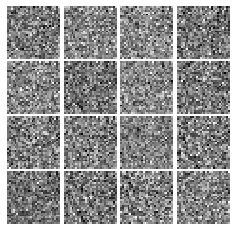


Iter: 0, D: 1.488, G:0.7228
Iter: 50, D: 0.3205, G:1.486
Iter: 100, D: 1.063, G:1.391
Iter: 150, D: 1.397, G:1.551
Iter: 200, D: 0.931, G:1.431


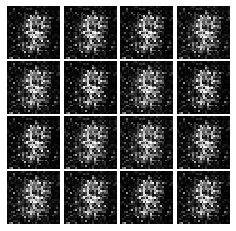


Iter: 250, D: 1.31, G:4.291
Iter: 300, D: 1.453, G:1.083
Iter: 350, D: 1.187, G:0.9199
Iter: 400, D: 2.394, G:0.4093
Iter: 450, D: 1.078, G:1.382


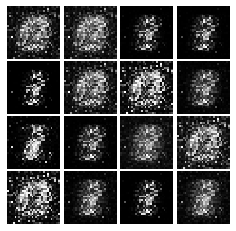


Iter: 500, D: 1.377, G:0.9443
Iter: 550, D: 1.332, G:1.18
Iter: 600, D: 0.8639, G:1.891
Iter: 650, D: 1.518, G:1.418
Iter: 700, D: 1.072, G:1.476


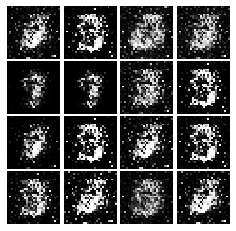


Iter: 750, D: 1.06, G:1.412
Iter: 800, D: 1.228, G:1.313
Iter: 850, D: 1.458, G:1.056
Iter: 900, D: 1.386, G:1.022
Iter: 950, D: 1.469, G:1.113


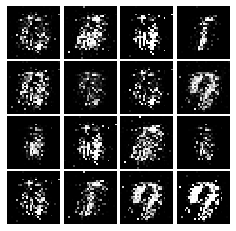


Iter: 1000, D: 1.261, G:1.315
Iter: 1050, D: 1.203, G:0.8886
Iter: 1100, D: 1.275, G:2.194
Iter: 1150, D: 1.319, G:0.9062
Iter: 1200, D: 1.515, G:0.6929


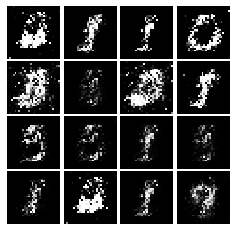


Iter: 1250, D: 1.66, G:0.661
Iter: 1300, D: 1.349, G:0.9532
Iter: 1350, D: 1.15, G:2.246
Iter: 1400, D: 1.2, G:1.994
Iter: 1450, D: 1.416, G:0.9843


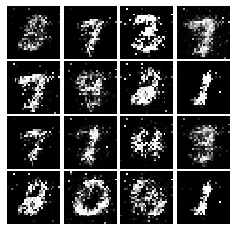


Iter: 1500, D: 1.317, G:0.8864
Iter: 1550, D: 1.234, G:1.189
Iter: 1600, D: 1.223, G:1.037
Iter: 1650, D: 1.27, G:0.9565
Iter: 1700, D: 1.298, G:1.892


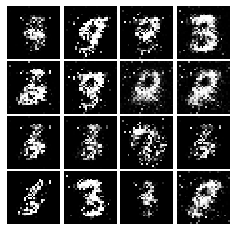


Iter: 1750, D: 1.285, G:1.025
Iter: 1800, D: 1.292, G:0.8539
Iter: 1850, D: 0.9583, G:1.164
Iter: 1900, D: 1.322, G:1.237
Iter: 1950, D: 1.33, G:0.9741


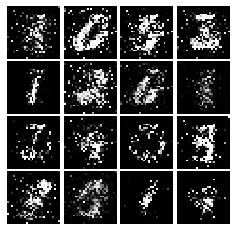


Iter: 2000, D: 1.209, G:0.987
Iter: 2050, D: 1.319, G:0.9807
Iter: 2100, D: 1.278, G:0.8292
Iter: 2150, D: 1.274, G:0.8436
Iter: 2200, D: 1.387, G:0.888


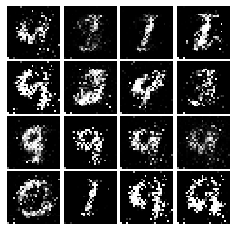


Iter: 2250, D: 1.336, G:1.08
Iter: 2300, D: 2.602, G:0.6039
Iter: 2350, D: 1.314, G:0.9101
Iter: 2400, D: 1.302, G:0.7664
Iter: 2450, D: 1.296, G:0.8254


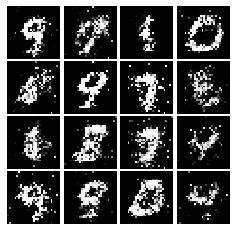


Iter: 2500, D: 1.326, G:0.8829
Iter: 2550, D: 1.389, G:0.783
Iter: 2600, D: 1.295, G:0.9052
Iter: 2650, D: 1.428, G:0.7644
Iter: 2700, D: 1.431, G:0.8193


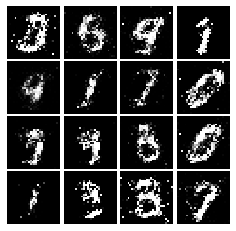


Iter: 2750, D: 1.271, G:0.8905
Iter: 2800, D: 1.309, G:0.9227
Iter: 2850, D: 1.294, G:0.8057
Iter: 2900, D: 1.252, G:0.8325
Iter: 2950, D: 1.334, G:0.7698


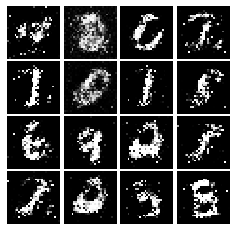


Iter: 3000, D: 1.226, G:0.7436
Iter: 3050, D: 1.29, G:0.8291
Iter: 3100, D: 1.38, G:0.8262
Iter: 3150, D: 1.341, G:0.8062
Iter: 3200, D: 1.433, G:0.724


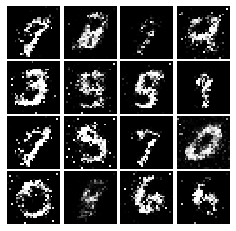


Iter: 3250, D: 1.356, G:0.8217
Iter: 3300, D: 1.359, G:0.8112
Iter: 3350, D: 1.275, G:0.8759
Iter: 3400, D: 1.332, G:0.7846
Iter: 3450, D: 1.394, G:1.232


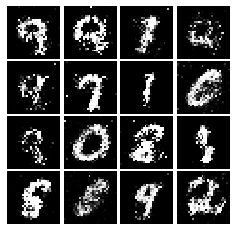


Iter: 3500, D: 1.329, G:0.8652
Iter: 3550, D: 1.278, G:0.7787
Iter: 3600, D: 1.3, G:0.8768
Iter: 3650, D: 1.355, G:0.7392
Iter: 3700, D: 1.397, G:0.7846


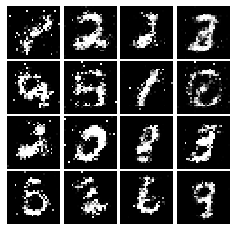


Iter: 3750, D: 1.305, G:0.8137
Iter: 3800, D: 1.349, G:0.6726
Iter: 3850, D: 1.303, G:0.8422
Iter: 3900, D: 1.399, G:0.7971
Iter: 3950, D: 1.404, G:0.8995


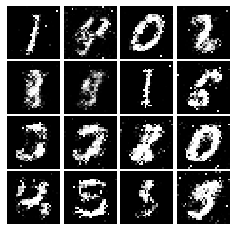


Iter: 4000, D: 1.291, G:0.882
Iter: 4050, D: 1.301, G:0.7993
Iter: 4100, D: 1.321, G:0.8032
Iter: 4150, D: 1.283, G:0.7686
Iter: 4200, D: 1.293, G:0.8821


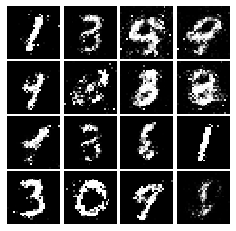


Iter: 4250, D: 1.276, G:0.7827
Final images


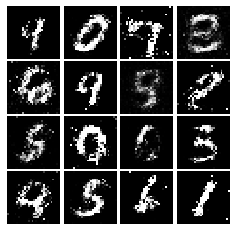

In [17]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [18]:
def lsgan_loss(scores_real, scores_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - scores_real: Tensor, shape [batch_size, 1], output of discriminator
        The score for each real image
    - scores_fake: Tensor, shape[batch_size, 1], output of discriminator
        The score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    
    real_images_loss = 0.5 * tf.reduce_mean((scores_real-1)**2)
    fake_images_loss = 0.5 * tf.reduce_mean(scores_fake**2)
    D_loss = real_images_loss + fake_images_loss
    
    G_loss = 0.5 * tf.reduce_mean((scores_fake - 1)**2)
    
    pass
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [19]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [20]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

_Run the following cell to train your model!_

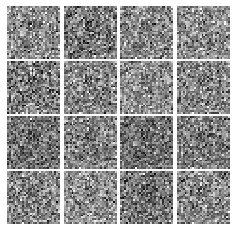


Iter: 0, D: 0.1021, G:0.4437
Iter: 50, D: 0.1362, G:0.4834
Iter: 100, D: 0.03593, G:0.5608
Iter: 150, D: 0.07427, G:0.4052
Iter: 200, D: 0.2532, G:0.08324


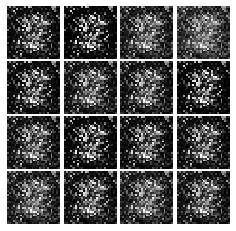


Iter: 250, D: 0.2011, G:0.9806
Iter: 300, D: 0.07893, G:0.437
Iter: 350, D: 0.2031, G:0.685
Iter: 400, D: 0.1385, G:0.4259
Iter: 450, D: 0.1407, G:0.3504


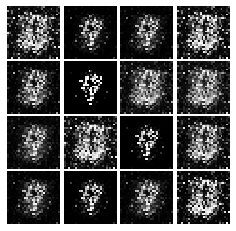


Iter: 500, D: 0.2158, G:0.175
Iter: 550, D: 0.1213, G:0.4259
Iter: 600, D: 0.1354, G:0.3567
Iter: 650, D: 0.1573, G:0.5738
Iter: 700, D: 0.1174, G:0.3685


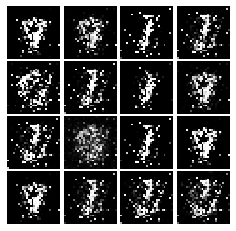


Iter: 750, D: 0.1517, G:0.3835
Iter: 800, D: 0.1356, G:0.4535
Iter: 850, D: 0.1304, G:0.3766
Iter: 900, D: 0.1356, G:0.3984
Iter: 950, D: 0.124, G:0.418


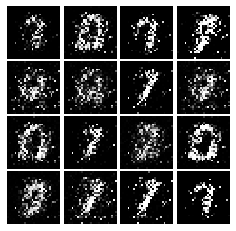


Iter: 1000, D: 0.1967, G:0.266
Iter: 1050, D: 0.1397, G:0.3732
Iter: 1100, D: 0.1517, G:0.2926
Iter: 1150, D: 0.1806, G:0.3334
Iter: 1200, D: 0.1859, G:0.2143


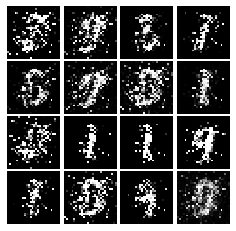


Iter: 1250, D: 0.1444, G:0.3047
Iter: 1300, D: 0.1929, G:0.2304
Iter: 1350, D: 0.1623, G:0.2266
Iter: 1400, D: 0.1563, G:0.2984
Iter: 1450, D: 0.1623, G:0.263


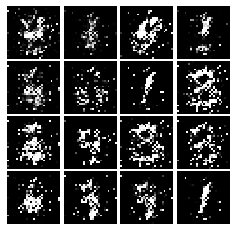


Iter: 1500, D: 0.1736, G:0.3094
Iter: 1550, D: 0.2271, G:0.3019
Iter: 1600, D: 0.1733, G:0.2759
Iter: 1650, D: 0.1671, G:0.245
Iter: 1700, D: 0.19, G:0.2155


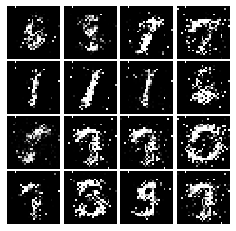


Iter: 1750, D: 0.1975, G:0.2147
Iter: 1800, D: 0.1984, G:0.2183
Iter: 1850, D: 0.1938, G:0.2144
Iter: 1900, D: 0.1935, G:0.2133
Iter: 1950, D: 0.1999, G:0.1861


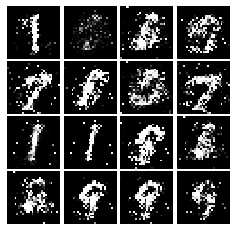


Iter: 2000, D: 0.2135, G:0.1931
Iter: 2050, D: 0.2163, G:0.2328
Iter: 2100, D: 0.2098, G:0.2
Iter: 2150, D: 0.2095, G:0.2047
Iter: 2200, D: 0.2302, G:0.1872


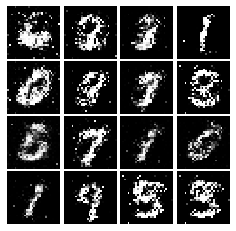


Iter: 2250, D: 0.2167, G:0.192
Iter: 2300, D: 0.2145, G:0.1973
Iter: 2350, D: 0.2173, G:0.1918
Iter: 2400, D: 0.2068, G:0.2423
Iter: 2450, D: 0.2142, G:0.1777


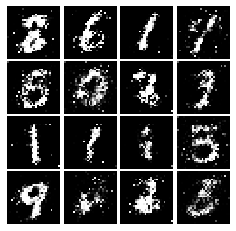


Iter: 2500, D: 0.2228, G:0.1934
Iter: 2550, D: 0.2006, G:0.1827
Iter: 2600, D: 0.1919, G:0.1818
Iter: 2650, D: 0.2323, G:0.1712
Iter: 2700, D: 0.2406, G:0.1667


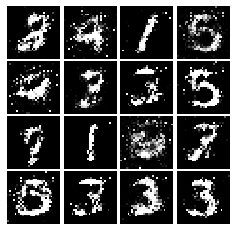


Iter: 2750, D: 0.2191, G:0.1766
Iter: 2800, D: 0.2253, G:0.1779
Iter: 2850, D: 0.2211, G:0.218
Iter: 2900, D: 0.2347, G:0.2288
Iter: 2950, D: 0.2203, G:0.1899


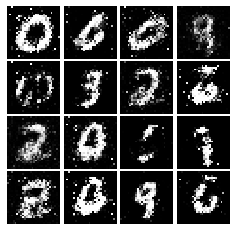


Iter: 3000, D: 0.2375, G:0.2185
Iter: 3050, D: 0.2208, G:0.2082
Iter: 3100, D: 0.2327, G:0.186
Iter: 3150, D: 0.2277, G:0.1774
Iter: 3200, D: 0.2252, G:0.1739


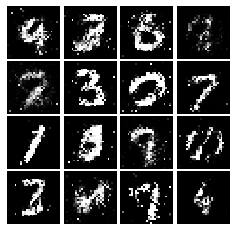


Iter: 3250, D: 0.2282, G:0.1727
Iter: 3300, D: 0.2311, G:0.169
Iter: 3350, D: 0.206, G:0.1712
Iter: 3400, D: 0.2319, G:0.1549
Iter: 3450, D: 0.2189, G:0.2047


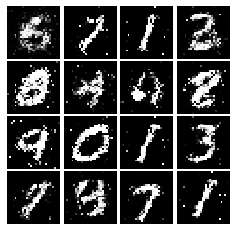


Iter: 3500, D: 0.2124, G:0.1736
Iter: 3550, D: 0.2304, G:0.181
Iter: 3600, D: 0.2455, G:0.1712
Iter: 3650, D: 0.2293, G:0.1832
Iter: 3700, D: 0.196, G:0.176


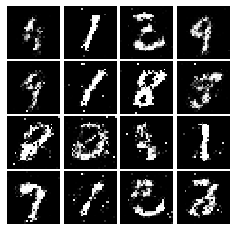


Iter: 3750, D: 0.2182, G:0.1641
Iter: 3800, D: 0.2119, G:0.1767
Iter: 3850, D: 0.2126, G:0.1752
Iter: 3900, D: 0.227, G:0.168
Iter: 3950, D: 0.2139, G:0.1786


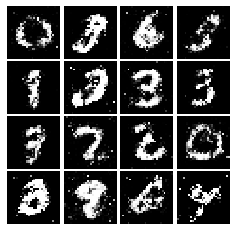


Iter: 4000, D: 0.2083, G:0.1824
Iter: 4050, D: 0.238, G:0.1662
Iter: 4100, D: 0.2296, G:0.2063
Iter: 4150, D: 0.2254, G:0.15
Iter: 4200, D: 0.2334, G:0.1578


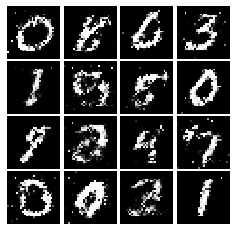


Iter: 4250, D: 0.2289, G:0.1558
Final images


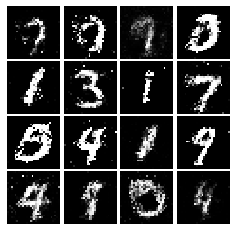

In [21]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. Please use `tf.layers` to define the following architecture:

Architecture:
* Conv2D: 32 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1, padding 0
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

Once again, please use biases for all convolutional and fully connected layers, and use the default parameter initializers. Note that a padding of 0 can be accomplished with the 'VALID' padding option.

In [22]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        
        reshaped_x = tf.reshape(x, [-1, 28, 28, 1])
        
        conv1 = tf.layers.conv2d(inputs=reshaped_x, filters=32, kernel_size=5, strides=1, padding="VALID", activation=leaky_relu)
        max_pool1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2)
        
        conv2 = tf.layers.conv2d(inputs=max_pool1, filters=64, kernel_size=5, strides=1, padding="VALID", activation=leaky_relu)
        max_pool2 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2)
        
        flatten1 = tf.reshape(max_pool2, shape=[-1, 4*4*64])
        fc1 = tf.layers.dense(inputs=flatten1, units=4*4*64, activation=leaky_relu)
        logits = tf.layers.dense(fc1, units=1)
        
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. Please use `tf.layers` for your implementation. You might find the documentation for [tf.layers.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose) useful. The architecture is as follows.

Architecture:
* Fully connected with output size 1024 
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* `ReLU`
* BatchNorm
* Resize into Image Tensor of size 7, 7, 128
* Conv2D^T (transpose): 64 filters of 4x4, stride 2
* `ReLU`
* BatchNorm
* Conv2d^T (transpose): 1 filter of 4x4, stride 2
* `TanH`

Once again, use biases for the fully connected and transpose convolutional layers. Please use the default initializers for your parameters. For padding, choose the 'same' option for transpose convolutions. For Batch Normalization, assume we are always in 'training' mode.

In [23]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        
        batch_size = z.shape[0]
        
        fc1 = tf.layers.dense(z, units=1024, activation=tf.nn.relu)
        bn_fc1 = tf.layers.batch_normalization(fc1, training=True)
        
        fc2 = tf.layers.dense(bn_fc1, units=7*7*128, activation=tf.nn.relu)
        bn_fc2 = tf.layers.batch_normalization(fc2, training=True)
        
        reshaped_output = tf.reshape(bn_fc2, shape=[-1, 7, 7, 128])
        
        conv1_T = tf.layers.conv2d_transpose(reshaped_output, filters=64, kernel_size=4, strides=2, 
                                             padding="SAME", activation=tf.nn.relu)
        bn_conv1_T = tf.layers.batch_normalization(conv1_T, training=True)
        conv2_T = tf.layers.conv2d_transpose(bn_conv1_T, filters=1, kernel_size=4, strides=2, 
                                             padding="SAME", activation=tf.nn.tanh)
        
        img = tf.reshape(conv2_T, [batch_size, 784])
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [24]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

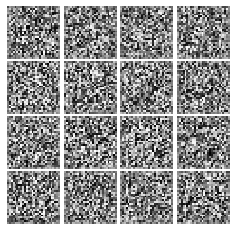


Iter: 0, D: 1.394, G:0.4758
Iter: 50, D: 2.601, G:0.698
Iter: 100, D: 1.478, G:3.303
Iter: 150, D: 0.9161, G:0.8673
Iter: 200, D: 1.018, G:0.9581


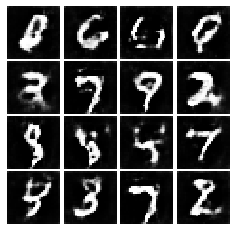


Iter: 250, D: 1.004, G:0.9932
Iter: 300, D: 1.051, G:1.067
Iter: 350, D: 1.172, G:0.9199
Iter: 400, D: 1.191, G:0.4673
Iter: 450, D: 1.211, G:0.534


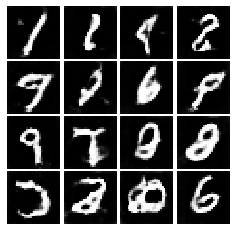


Iter: 500, D: 1.119, G:0.8659
Iter: 550, D: 1.203, G:0.9005
Iter: 600, D: 1.193, G:1.248
Iter: 650, D: 1.151, G:1.119
Iter: 700, D: 1.173, G:0.8872


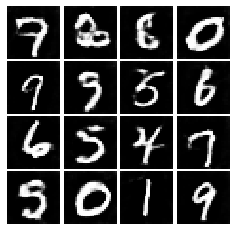


Iter: 750, D: 1.148, G:0.8404
Iter: 800, D: 1.098, G:0.8907
Iter: 850, D: 1.116, G:1.029
Iter: 900, D: 1.187, G:1.265
Iter: 950, D: 1.159, G:0.9576


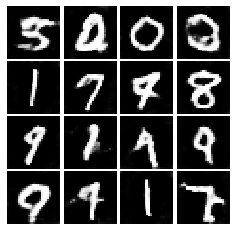


Iter: 1000, D: 1.194, G:0.9131
Iter: 1050, D: 1.233, G:0.6716
Iter: 1100, D: 1.173, G:1.025
Iter: 1150, D: 1.231, G:0.832
Iter: 1200, D: 1.183, G:0.7211


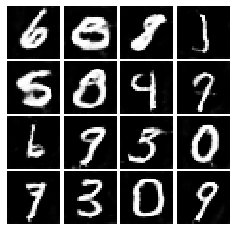


Iter: 1250, D: 1.184, G:0.9092
Iter: 1300, D: 1.2, G:1.032
Iter: 1350, D: 1.111, G:1.34
Iter: 1400, D: 1.176, G:1.112
Iter: 1450, D: 1.238, G:1.653


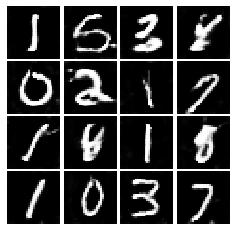


Iter: 1500, D: 1.153, G:1.106
Iter: 1550, D: 1.218, G:1.015
Iter: 1600, D: 1.087, G:0.9347
Iter: 1650, D: 1.215, G:0.6556
Iter: 1700, D: 1.066, G:0.801


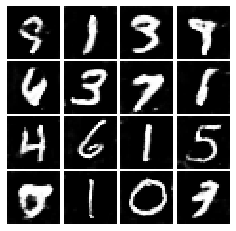


Iter: 1750, D: 1.129, G:1.038
Iter: 1800, D: 1.026, G:0.95
Iter: 1850, D: 1.142, G:1.379
Iter: 1900, D: 1.145, G:0.9457
Iter: 1950, D: 1.138, G:1.356


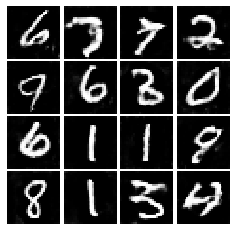


Iter: 2000, D: 1.164, G:1.164
Iter: 2050, D: 1.158, G:0.868
Iter: 2100, D: 1.126, G:1.136
Final images


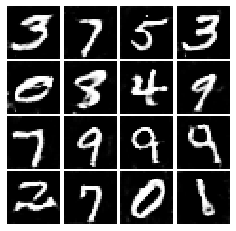

In [25]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=5)

## INLINE QUESTION 1

We will look at an example to see why alternating minimization of the same objective (like in a GAN) can be tricky business.

Consider $f(x,y)=xy$. What does $\min_x\max_y f(x,y)$ evaluate to? (Hint: minmax tries to minimize the maximum value achievable.)

Now try to evaluate this function numerically for 6 steps, starting at the point $(1,1)$, 
by using alternating gradient (first updating y, then updating x) with step size $1$. 
You'll find that writing out the update step in terms of $x_t,y_t,x_{t+1},y_{t+1}$ will be useful.

Record the six pairs of explicit values for $(x_t,y_t)$ in the table below.

### Your answer:
 
 $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_5$ | $y_6$ 
 ----- | ----- | ----- | ----- | ----- | ----- | ----- 
   1   |       |       |       |       |       |       
 $x_0$ | $x_1$ | $x_2$ | $x_3$ | $x_4$ | $x_5$ | $x_6$ 
   1   |       |       |       |       |       |       
   

## INLINE QUESTION 2
Using this method, will we ever reach the optimal value? Why or why not?

### Your answer:

## INLINE QUESTION 3
If the generator loss decreases during training while the discriminator loss stays at a constant high value from the start, is this a good sign? Why or why not? A qualitative answer is sufficient

### Your answer: